In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
import pandas as pd
import cmath
import math
import time
import  matplotlib.pyplot as plt
Line=pd.read_csv("14_line.csv")       # Reading Line data from csv file
L=np.array(Line["L"]).reshape(-1,1)   # Line Number
F=np.array(Line["F"]).reshape(-1,1)   # From Bus
T=np.array(Line["T"]).reshape(-1,1)   # To Bus
LType=np.array(Line["Ltype"]).reshape(-1,1)


In [2]:
# Load Flow with PST
def Load_Flow(X1,X2):
    # Line Data Reading From CSV file
    Line=pd.read_csv("14_line.csv")       # Reading Line data from csv file
    L=np.array(Line["L"]).reshape(-1,1)   # Line Number
    F=np.array(Line["F"]).reshape(-1,1)   # From Bus
    T=np.array(Line["T"]).reshape(-1,1)   # To Bus
    r=np.array(Line["R"]).reshape(-1,1)   # Line Resistance in p.u.
    x=np.array(Line["X"]).reshape(-1,1)   # Line Reactace in p.u. 
    b1=np.array(Line["B"]).reshape(-1,1)  # Half line charging admittance
    tr=np.array(Line["tr"]).reshape(-1,1)
    LType=np.array(Line["Ltype"]).reshape(-1,1)
    Line_Lim=np.array(Line["Lim"]).reshape(-1,1)
    nbus=int(max(max(F),max(T)))          # Number of Buses
    nL=len(F)                             # Number of Transmission Line
    z=r+(0+1j)*x                          #  Line Impedances
    y=np.reciprocal(z)                    # Line admittance

    # formation of Smax matix
    Smax=np.zeros([nbus,nbus],dtype=float)
    for i in range(nL):
        m=F[i]
        n=T[i]
        f1=np.where(F.flatten()==m)
        f2=np.where(T.flatten()==n)
        l1=np.intersect1d(f1,f2).item()
        Smax[m-1,n-1]=Line_Lim[l1]  
    # bus data Reading From CSV file
    bus=pd.read_csv("14_bus.csv")                       # Reading Bus data from csv file
    Bus_No=np.array(bus["bus_no"]).reshape(-1,1)        # Bus Number
    Vm=np.array(bus["Vm"]).reshape(-1,1).astype(float)  # Voltage Magnitude
    Va=np.array(bus["Va"]).reshape(-1,1).astype(float)  # Voltage Angle
    Pg=np.array(bus["Pg"]).reshape(-1,1).astype(float)/100  # Active Power Generation
    Qg=np.array(bus["Qg"]).reshape(-1,1).astype(float)/100  # Reactive Power Generation
    Pl=np.array(bus["Pl"]).reshape(-1,1).astype(float)/100  # Active Load
    Ql=np.array(bus["Ql"]).reshape(-1,1).astype(float)/100
    Qmin=np.array(bus["Qmin"]).reshape(-1,1).astype(float)/100
    Qmax=np.array(bus["Qmax"]).reshape(-1,1).astype(float)/100
    # Reactive Load
    Type=np.array(bus["Type"]).reshape(-1) # Type of bus (1-slack),(2-PV),(3-PQ)
    pq=np.array(np.where(Type==3)).reshape(-1).tolist() #  PQ Buses
    pv=np.array(np.where(Type==2)).reshape(-1).tolist() #  PV Buses
    # No of PQ Bus
    npq=len(pq)
    # No of PV Bus
    npv=len(pv)
    Psp=Pg-Pl
    Qsp=Qg-Ql
    
    
    x2=X2
    # Formation of Ybus Matrix with PST
    Ybus=np.asmatrix(np.zeros([nbus,nbus],dtype=complex))
    t=cmath.rect(1,x2*math.pi/180)
    W=np.where(L==X1)
    # off Diagonal Elements
    for k in range(nL):
        # for PST
        
        if F[k]==F[W] and T[k]==T[W] and LType[k]==1:
            Ybus[int(F[k])-1,int(T[k])-1]=-np.conj(t)*y[k]
            Ybus[int(T[k])-1,int(F[k])-1]=-t*y[k]
        # for Line and transformer
        else:
            Ybus[int(F[k])-1,int(T[k])-1]=-y[k]/tr[k]
            Ybus[int(T[k])-1,int(F[k])-1]=-y[k]/tr[k]
    # Diagonal Elements
    # for line and transformer
    for i in range(nbus):
        for l in range(nL):
            if F[l]==i+1:
               Ybus[i,i]=Ybus[i,i]+y[l]/tr[l]**2+(0+1j)*b1[l]
            elif T[l]==i+1:
               Ybus[i,i]=Ybus[i,i]+y[l]+(0+1j)*b1[l]
    # for PST
    for k in range(nL):
        if F[k]==F[W] and T[k]==T[W] and LType[k]==1:
            Ybus[int(F[k])-1,int(F[k])-1]=Ybus[int(F[k])-1,int(F[k])-1]-(0+1j)*b1[k]
            Ybus[int(T[k])-1,int(T[k])-1]=Ybus[int(T[k])-1,int(T[k])-1]-(0+1j)*b1[k]

    Ym=abs(Ybus)
    Ya=np.angle(Ybus)
    # Newton Raphson 
    Iter=1
    while True:
        P=np.zeros([nbus,1])
        Q=np.zeros([nbus,1])
        for i in range(nbus):
            for k in range(nbus):
                P[i]=P[i]+Vm[i]*Vm[k]*Ym[i,k]*math.cos(Va[k]-Va[i]+Ya[i,k])
                Q[i]=Q[i]-Vm[i]*Vm[k]*Ym[i,k]*math.sin(Va[k]-Va[i]+Ya[i,k])
        # Checking Q Limit Voilations
#         if Iter<=7 and Iter>2:
#             for n in range(1,nbus):
#                 if Type[n]==2:
#                     QG=Q[n]+Ql[n]
#                     if QG<Qmin[n]:
#                         Vm[n]=Vm[n]+0.01
#                     elif QG>Qmax[n]:
#                         Vm[n]=Vm[n]-0.01

        #power Injections
        dPa=P-Psp
        dQa=Q-Qsp
        k=0
        dQ=np.zeros([npq,1])
        for i in range(nbus):
            if Type[i]==3:
                dQ[k]=dQa[i]
                k=k+1
        dP=dPa[1:]
        Miss_Match=np.vstack((dP,dQ))

        # Calculation of Jacobian Matrix
        #Calculating J1
        J1=np.zeros([nbus-1,nbus-1])
        for i in range(nbus-1):
            m=i+1
            for j in range(nbus-1):
                n=j+1
                if n==m:
                    for n in range(nbus):
                        J1[i,j]=J1[i,j]+Vm[m]*Vm[n]*Ym[m,n]*math.sin(Va[n]-Va[m]+Ya[m,n])
                    J1[i,j]=J1[i,j]-Vm[m]*Vm[m]*Ym[m,m]*math.sin(Ya[m,m])
                else:
                    J1[i,j]=-Vm[m]*Vm[n]*Ym[m,n]*math.sin(Va[n]-Va[m]+Ya[m,n])
        #
        # calulating J2          
        J2=np.zeros([nbus-1,npq])
        for i in range(nbus-1):
            m=i+1
            for k in range(npq):
                n=pq[k]
                if n==m:
                    for n in range(nbus):
                        J2[i,k]=J2[i,k]+Vm[n]*Ym[m,n]*math.cos(Va[n]-Va[m]+Ya[m,n])
                    J2[i,k]=J2[i,k]+Vm[m]*Ym[m,m]*math.cos(Ya[m,m])
                else:
                    J2[i,k]=Vm[m]*Ym[m,n]*math.cos(Va[n]-Va[m]+Ya[m,n])
        #
        # Calculating J3
        J3=np.zeros([npq,nbus-1])
        for i in range(npq):
            m=pq[i]
            for k in range(nbus-1):
                n=k+1
                if n==m:
                    for n in range(nbus):
                        J3[i,k]=J3[i,k]+Vm[m]*Vm[n]*Ym[m,n]*math.cos(Va[n]-Va[m]+Ya[m,n])
                    J3[i,k]=J3[i,k]-Vm[m]*Vm[m]*Ym[m,m]*math.cos(Ya[m,m])
                else:
                    J3[i,k]=-Vm[m]*Vm[n]*Ym[m,n]*math.cos(Va[n]-Va[m]+Ya[m,n])
        #
        #     # Calculating J4
        J4=np.zeros([npq,npq])
        for i in range(npq):
            m=pq[i]
            for k in range(npq):
                n=pq[k]
                if n==m:
                    for n in range(nbus):
                        J4[i,k]=J4[i,k]-Vm[n]*Ym[m,n]*math.sin(Va[n]-Va[m]+Ya[m,n])
                    J4[i,k]=J4[i,k]-Vm[m]*Ym[m,m]*math.sin(Ya[m,m])
                else:
                    J4[i,k]=-Vm[m]*Ym[m,n]*math.sin(Va[n]-Va[m]+Ya[m,n])
        #
        # Final Jacobian Matrix
        A=np.vstack((J1,J3))
        B=np.vstack((J2,J4))
        J=np.hstack((A,B))
        # Chane in Angle And Voltages

        dX=-np.dot(np.linalg.inv(J),Miss_Match)

        #Updating Voltage Angle Value
        dVa=dX[0:nbus-1]
        dVm=dX[nbus-1:]
        Va[1:]=Va[1:]+dVa
        Va=np.vstack((Va[0],Va[1:]))

        k=0
        for i in range(1,nbus):
            if Type[i]==3: # PQ bus
                Vm[i]=dVm[k]+Vm[i]
                k=k+1
        #
        Tol=max(abs(Miss_Match))
        Iter=Iter+1
        if Tol<0.00001 or Iter==10:
            break

    #combining magitude and voltages        
    V=np.zeros([nbus,1],dtype=complex)
    for i in range(nbus):
        V[i]=cmath.rect(Vm[i],Va[i])
    # Calculating Line current and Line Power Flows 
    Iij=np.zeros([nbus,nbus],dtype=complex)
    Sij=np.zeros([nbus,nbus],dtype=complex)
    gama=np.zeros([nbus,nbus],dtype=float)
    Si=np.zeros([nbus,1],dtype=complex)
    #Line Current Flows
    for i in range(nL):
        m=F[i]
        n=T[i]
        f1=np.where(F.flatten()==m)
        f2=np.where(T.flatten()==n)
        l1=np.intersect1d(f1,f2).item()
        if m==F[W] and n==T[W]:
            Iij[m-1,n-1]=cmath.rect(1,x2*math.pi/180)*(V[m-1]*cmath.rect(1,x2*math.pi/180)-V[n-1])*y[W]
            
        else:
            Iij[m-1,n-1]=((V[m-1]/tr[l1]-V[n-1])*y[l1]+V[m-1]*(0+1j)*b1[l1])/tr[l1]
            


    #Line Power Flows
    for i in range(nbus):
        for j in range(nbus):
            if i!=j:
                Sij[i,j]=V[i]*np.conj(Iij[i,j])
                
    for i in range(nbus):
        for j in range(nbus):
            if i<j and abs(Sij[i,j])!=0 and Smax[i,j]!=0:
                gama[i,j]=abs(Sij[i,j])/Smax[i,j]
    for i in range(nbus):
        for j in range(nbus):
            if gama[i,j]>1:
                gama[i,j]=gama[i,j]+100
    
    s=np.sum(gama**2) 

    Pij=Sij.real
    Qij=Sij.imag


#     df=pd.DataFrame(np.hstack((Bus_No,Vm,Va*180/math.pi,Pi*100,Qi*100,PG*100,QG*100,Pl*100,Ql*100)))
#     df.columns = ['Bus_No','V_mag','V_ang','Pi','Qi','PG','QG','Pl','Ql']
    Vm[1:]=np.ones([nbus-1,1])
    Va=np.zeros([nbus,1])
    return s



In [3]:
# Brute Force Algorithm
start=time.time()
tp=np.linspace(-10,10,21).astype('int')
M=np.zeros([7,len(tp)])
for i in range(7):
    if LType[i]==1:
        m=int(L[i])
        for j in range(len(tp)):
            n=int(tp[j])
            M[i,j]=Load_Flow(m,n)
    else:
        for j in range(len(tp)):
            M[i,j]=10000

result=np.where(M==np.amin(M))
a,b=result

if M[int(a),int(b)]<10000:
    Line_No=int(L[int(a)])
    Tap_Pos=tp[int(b)]
    print("Line Number:{}".format(Line_No))
    print("From Bus:{}".format(int(F[int(a)])))
    print("To Bus:{}".format(int(T[int(a)])))
    print("PST Tap setting:{}".format(Tap_Pos))
    print("Objective Function Value:{}".format(M[int(a),int(b)]))
else:
    print("There is No Solution")
end= time.time()
Time=(end-start)
print("Total Execution Time is: {} Second".format(Time))

Line Number:1
From Bus:1
To Bus:2
PST Tap setting:-8
Objective Function Value:5.901951749490558
Total Execution Time is: 6.5351386070251465 Second


Text(0.5, 0, 'Lines')

Text(0, 0.5, 'Power Flows (p.u.)')

([<matplotlib.axis.XTick at 0x1bae3ca44f0>,
 [Text(0, 0, ' 1-2'),
  Text(1, 0, ' 1-5'),
  Text(2, 0, ' 2-3'),
  Text(3, 0, ' 2-4'),
  Text(4, 0, ' 2-5'),
  Text(5, 0, ' 3-4'),
  Text(6, 0, ' 4-5'),
  Text(7, 0, ' 4-7'),
  Text(8, 0, ' 4-9'),
  Text(9, 0, ' 5-6'),
  Text(10, 0, '6-11'),
  Text(11, 0, ' 6-12'),
  Text(12, 0, ' 6-13'),
  Text(13, 0, ' 7-8'),
  Text(14, 0, ' 7-9'),
  Text(15, 0, '9-10'),
  Text(16, 0, ' 9-14'),
  Text(17, 0, ' 10-11'),
  Text(18, 0, ' 12-13'),
  Text(19, 0, ' 13-14')])

Text(1, 1.25, 'Power flow limit for line 1-2 ')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, ' 1-2'),
  Text(1, 0, ' 1-5'),
  Text(2, 0, ' 2-3'),
  Text(3, 0, ' 2-4'),
  Text(4, 0, ' 2-5'),
  Text(5, 0, ' 3-4'),
  Text(6, 0, ' 4-5'),
  Text(7, 0, ' 4-7'),
  Text(8, 0, ' 4-9'),
  Text(9, 0, ' 5-6'),
  Text(10, 0, '6-11'),
  Text(11, 0, ' 6-12'),
  Text(12, 0, ' 6-13'),
  Text(13, 0, ' 7-8'),
  Text(14, 0, ' 7-9'),
  Text(15, 0, '9-10'),
  Text(16, 0, ' 9-14'),
  Text(17, 0, ' 10-11'),
  Text(18, 0, ' 12-13'),
  Text(19, 0, ' 13-14')])

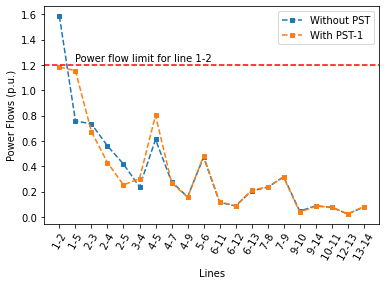

In [2]:
pf=pd.read_csv("14_bus_pf.csv") 
without_PST=np.array(pf["base"])
with_PST=np.array(pf["1pst"])
Line=np.array(pf["Line"])
bar1=np.arange(len(Line))
plt.plot(bar1,without_PST, linestyle = 'dashed',marker='s',ms=4,label="Without PST")
plt.plot(bar1,with_PST, linestyle = 'dashed',marker='s',ms=4,label="With PST-1")
plt.xlabel("Lines")
plt.ylabel("Power Flows (p.u.)")
#plt.title("Line Flows")
plt.xticks(bar1,Line)
plt.axhline(y = 1.2, color = 'Red', linestyle = 'dashed')
plt.text(1, 1.25, 'Power flow limit for line 1-2 ', ha='left', va='center')
plt.legend(loc=1)
plt.xticks(rotation=60)
plt.savefig("14_1_plot.pdf",format="pdf",bbox_inches="tight")
plt.show()

Text(0.5, 0, 'Lines')

Text(0, 0.5, 'Power Flows (p.u.)')

([<matplotlib.axis.XTick at 0x1bae450e5e0>,
 [Text(0, 0, ' 1-2'),
  Text(1, 0, ' 1-5'),
  Text(2, 0, ' 2-3'),
  Text(3, 0, ' 2-4'),
  Text(4, 0, ' 2-5'),
  Text(5, 0, ' 3-4'),
  Text(6, 0, ' 4-5'),
  Text(7, 0, ' 4-7'),
  Text(8, 0, ' 4-9'),
  Text(9, 0, ' 5-6'),
  Text(10, 0, '6-11'),
  Text(11, 0, ' 6-12'),
  Text(12, 0, ' 6-13'),
  Text(13, 0, ' 7-8'),
  Text(14, 0, ' 7-9'),
  Text(15, 0, '9-10'),
  Text(16, 0, ' 9-14'),
  Text(17, 0, ' 10-11'),
  Text(18, 0, ' 12-13'),
  Text(19, 0, ' 13-14')])

Text(1, 1.25, 'Power flow limit for line 1-2 ')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, ' 1-2'),
  Text(1, 0, ' 1-5'),
  Text(2, 0, ' 2-3'),
  Text(3, 0, ' 2-4'),
  Text(4, 0, ' 2-5'),
  Text(5, 0, ' 3-4'),
  Text(6, 0, ' 4-5'),
  Text(7, 0, ' 4-7'),
  Text(8, 0, ' 4-9'),
  Text(9, 0, ' 5-6'),
  Text(10, 0, '6-11'),
  Text(11, 0, ' 6-12'),
  Text(12, 0, ' 6-13'),
  Text(13, 0, ' 7-8'),
  Text(14, 0, ' 7-9'),
  Text(15, 0, '9-10'),
  Text(16, 0, ' 9-14'),
  Text(17, 0, ' 10-11'),
  Text(18, 0, ' 12-13'),
  Text(19, 0, ' 13-14')])

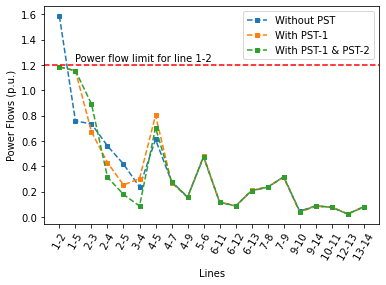

In [3]:
pf=pd.read_csv("14_bus_pf.csv") 
without_PST=np.array(pf["base"])
with_1_PST=np.array(pf["1pst"])
with_2_PST=np.array(pf["2pst"])
Line=np.array(pf["Line"])
bar1=np.arange(len(Line))
plt.plot(bar1,without_PST, linestyle = 'dashed',marker='s',ms=4,label="Without PST")
plt.plot(bar1,with_1_PST, linestyle = 'dashed',marker='s',ms=4,label="With PST-1")
plt.plot(bar1,with_2_PST, linestyle = 'dashed',marker='s',ms=4,label="With PST-1 & PST-2")
plt.xlabel("Lines")
plt.ylabel("Power Flows (p.u.)")
#plt.title("Line Flows")
plt.xticks(bar1,Line)
plt.axhline(y = 1.2, color = 'Red', linestyle = 'dashed')
plt.text(1, 1.25, 'Power flow limit for line 1-2 ', ha='left', va='center')
plt.legend(loc=1)
plt.xticks(rotation=60)
plt.savefig("14_12_plot.pdf",format="pdf",bbox_inches="tight")
plt.show()